In [1]:
print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [45]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
def calcEigenfaces(n_components=100):
    
    print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print "done in %0.3fs" % (time() - t0)

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print "Projecting the input data on the eigenfaces orthonormal basis"
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print "done in %0.3fs" % (time() - t0)


    ###############################################################################
    # Train a SVM classification model

    print "Fitting the classifier to the training set"
    t0 = time()
    param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
    # for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    print "done in %0.3fs" % (time() - t0)
    print "Best estimator found by grid search:"
    print clf.best_estimator_

    ###############################################################################
    # Quantitative evaluation of the model quality on the test set

    print "Predicting the people names on the testing set"
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print "done in %0.3fs" % (time() - t0)

    print classification_report(y_test, y_pred, target_names=target_names)
    print confusion_matrix(y_test, y_pred, labels=range(n_classes))
    return eigenfaces



10
Extracting the top 10 eigenfaces from 966 faces
done in 0.029s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
Fitting the classifier to the training set


E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 67.949s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.022s
                   precision    recall  f1-score   support

     Ariel Sharon       0.14      0.23      0.17        13
     Colin Powell       0.47      0.50      0.48        60
  Donald Rumsfeld       0.20      0.30      0.24        27
    George W Bush       0.67      0.58      0.62       146
Gerhard Schroeder       0.11      0.12      0.12        25
      Hugo Chavez       0.17      0.13      0.15        15
       Tony Blair       0.50      0.42      0.45        36

      avg / total       0.49      0.45      0.47       322

[[ 3  4  1  3  0  2  0]
 [11 30  8  8  2  0  1]
 [ 2  6  8  7  1  1  2]
 [ 3 18 12 85 15  5  8]
 [ 0  2  3 11  3  2  4]


E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 21.369s
Best estimator found by grid search:
SVC(C=50000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.013s
                   precision    recall  f1-score   support

     Ariel Sharon       0.26      0.38      0.31        13
     Colin Powell       0.63      0.73      0.68        60
  Donald Rumsfeld       0.46      0.67      0.55        27
    George W Bush       0.87      0.68      0.77       146
Gerhard Schroeder       0.39      0.48      0.43        25
      Hugo Chavez       0.38      0.40      0.39        15
       Tony Blair       0.50      0.44      0.47        36

      avg / total       0.66      0.62      0.64       322

[[  5   5   2   1   0   0   0]
 [  7  44   3   4   1   1   0]
 [  3   1  18   4   0   0   1]
 [  1  14  12 100   8  

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 10.120s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.016s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.62      0.64        13
     Colin Powell       0.72      0.87      0.79        60
  Donald Rumsfeld       0.58      0.56      0.57        27
    George W Bush       0.85      0.88      0.86       146
Gerhard Schroeder       0.62      0.52      0.57        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.68      0.53      0.59        36

      avg / total       0.75      0.76      0.75       322

[[  8   4   0   1   0   0   0]
 [  2  52   4   2   0   0   0]
 [  1   3  15   8   0   0   0]
 [  1  10   5 128   1   0 

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 8.260s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.025s
                   precision    recall  f1-score   support

     Ariel Sharon       0.59      0.77      0.67        13
     Colin Powell       0.81      0.90      0.85        60
  Donald Rumsfeld       0.70      0.59      0.64        27
    George W Bush       0.87      0.90      0.89       146
Gerhard Schroeder       0.73      0.64      0.68        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.87      0.72      0.79        36

      avg / total       0.82      0.82      0.81       322

[[ 10   1   2   0   0   0   0]
 [  1  54   1   3   1   0   0]
 [  3   2  16   5   1   0   0]
 [  2   8   3 131   1   1  

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 14.607s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.038s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.79      0.90      0.84        60
  Donald Rumsfeld       0.76      0.59      0.67        27
    George W Bush       0.86      0.95      0.90       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       0.90      0.72      0.80        36

      avg / total       0.84      0.84      0.83       322

[[  9   1   1   2   0   0   0]
 [  0  54   0   5   0   0   1]
 [  3   1  16   7   0   0   0]
 [  1   6   1 138   0   0

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.265s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.049s
Fitting the classifier to the training set
done in 36.387s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.100s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.74      0.63      0.68        27
    George W Bush       0.91      0.94      0.92       146
Gerhard Schroeder       0.87      0.80      0.83        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.88      0.83      0.86        36

      avg / total       0.85      0.85     

In [46]:
n_components = [10, 15, 25, 50, 100, 250]

#eigenfaces = 
for i in n_components:
    print i
    calcEigenfaces(i)

10
Extracting the top 10 eigenfaces from 966 faces
done in 0.049s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.002s
Fitting the classifier to the training set


E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 76.104s
Best estimator found by grid search:
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.000s
                   precision    recall  f1-score   support

     Ariel Sharon       0.10      0.15      0.12        13
     Colin Powell       0.51      0.60      0.55        60
  Donald Rumsfeld       0.24      0.33      0.28        27
    George W Bush       0.71      0.61      0.65       146
Gerhard Schroeder       0.15      0.16      0.15        25
      Hugo Chavez       0.24      0.27      0.25        15
       Tony Blair       0.54      0.36      0.43        36

      avg / total       0.52      0.49      0.50       322

[[ 2  5  3  2  0  1  0]
 [ 7 36  6  6  4  0  1]
 [ 1  5  9  7  1  2  2]
 [ 9 16  8 89 13  6  5]
 [ 0  4  3  7  4  4 

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 19.483s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.015s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.38      0.43        13
     Colin Powell       0.70      0.78      0.74        60
  Donald Rumsfeld       0.44      0.52      0.47        27
    George W Bush       0.77      0.76      0.76       146
Gerhard Schroeder       0.60      0.36      0.45        25
      Hugo Chavez       0.60      0.60      0.60        15
       Tony Blair       0.50      0.53      0.51        36

      avg / total       0.67      0.66      0.66       322

[[  5   3   2   3   0   0   0]
 [  4  47   1   6   0   0   2]
 [  1   2  14  10   0   0   0]
 [  0   9  14 111   4   0  

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 9.954s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.031s
                   precision    recall  f1-score   support

     Ariel Sharon       0.40      0.62      0.48        13
     Colin Powell       0.72      0.85      0.78        60
  Donald Rumsfeld       0.56      0.67      0.61        27
    George W Bush       0.87      0.83      0.85       146
Gerhard Schroeder       0.62      0.52      0.57        25
      Hugo Chavez       0.62      0.53      0.57        15
       Tony Blair       0.73      0.53      0.61        36

      avg / total       0.75      0.74      0.74       322

[[  8   3   1   1   0   0   0]
 [  3  51   3   2   1   0   0]
 [  3   2  18   4   0   0   0]
 [  5   9   9 121   1   0  

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 8.246s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.034s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.83      0.88      0.85        60
  Donald Rumsfeld       0.70      0.59      0.64        27
    George W Bush       0.84      0.90      0.87       146
Gerhard Schroeder       0.74      0.56      0.64        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.81      0.69      0.75        36

      avg / total       0.80      0.80      0.80       322

[[ 10   1   2   0   0   0   0]
 [  1  53   1   4   1   0   0]
 [  2   2  16   7   0   0   0]
 [  2   5   3 131   0   1  

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 14.522s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.054s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.80      0.92      0.85        60
  Donald Rumsfeld       0.77      0.63      0.69        27
    George W Bush       0.88      0.94      0.91       146
Gerhard Schroeder       0.83      0.76      0.79        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.90      0.78      0.84        36

      avg / total       0.85      0.85      0.84       322

[[  9   1   1   2   0   0   0]
 [  0  55   1   4   0   0   0]
 [  3   2  17   5   0   0   0]
 [  1   7   1 137   0   0

E:\dev\installed\Anaconda3\envs\python27\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.259s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.025s
Fitting the classifier to the training set
done in 36.296s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.100s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.83      0.90      0.86        60
  Donald Rumsfeld       0.79      0.70      0.75        27
    George W Bush       0.92      0.93      0.93       146
Gerhard Schroeder       0.85      0.92      0.88        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.85      0.81      0.83        36

      avg / total       0.86      0.86     

In [41]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())
        


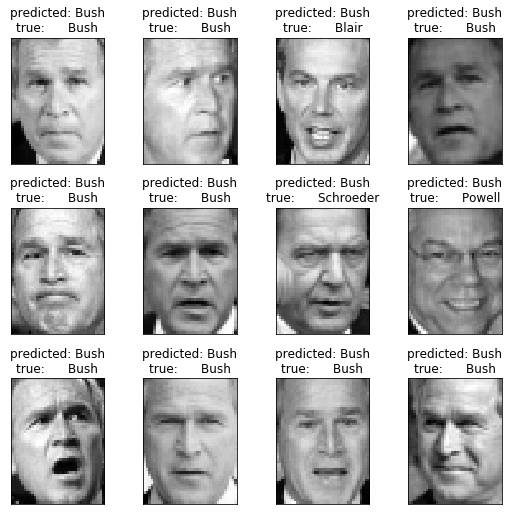

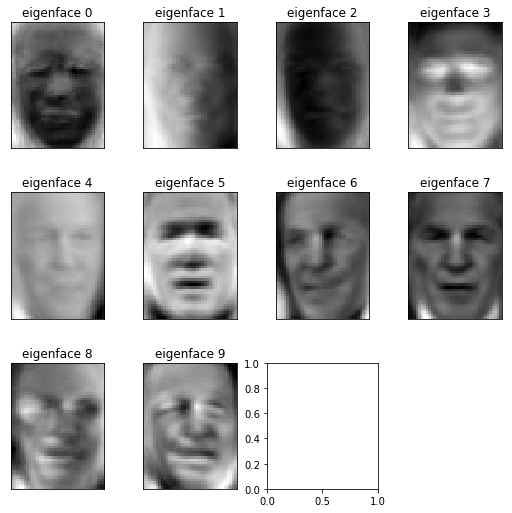

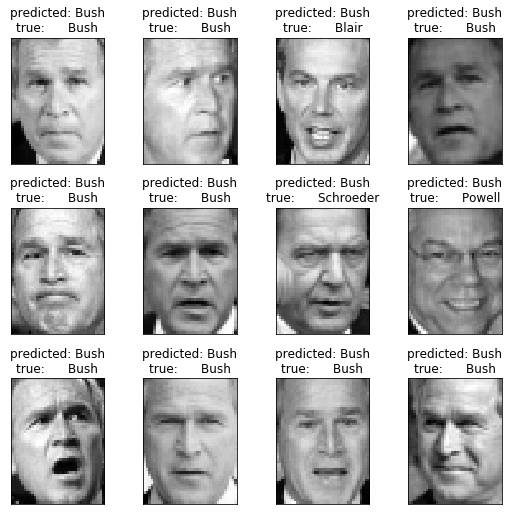

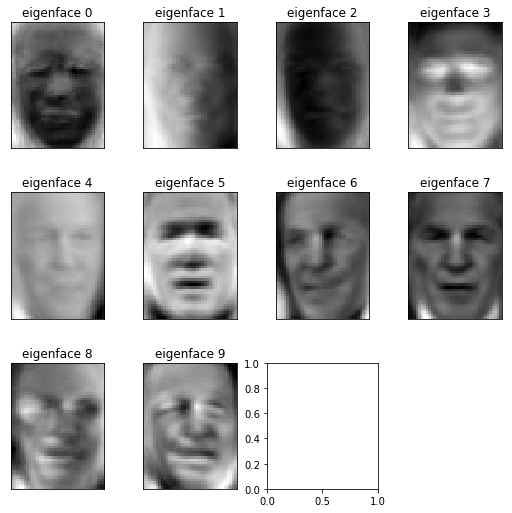

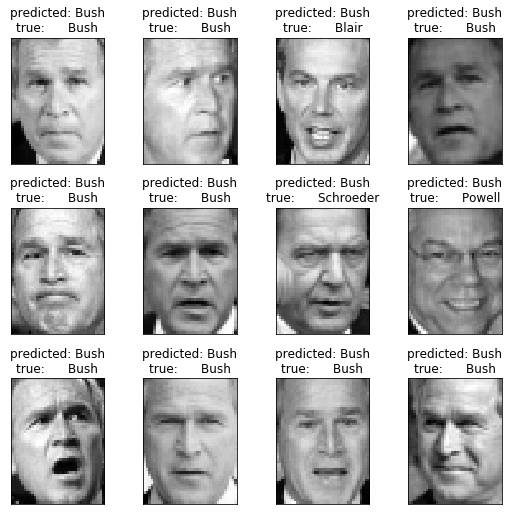

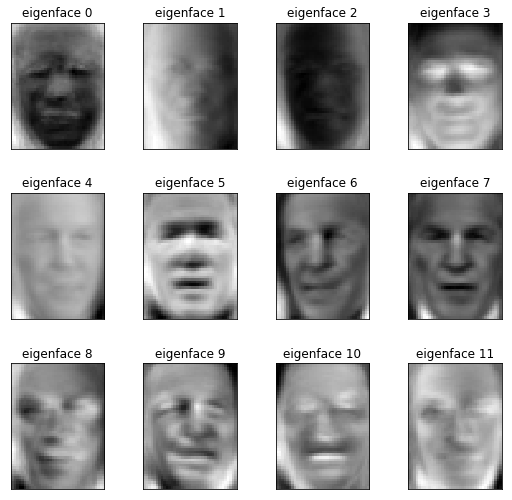

In [42]:
plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

(150L, 50L, 37L)